In [ ]:
# hide
# all_tutorial
! [ -e /content ] && pip install -Uqq mrl-pypi  # upgrade mrl on colab

# Tutorial - Combichem

>Tutorial on using MRL combichem module

This tutorial gives an introduction to the MRL combichem module

## Performance Notes

The workflow in this notebook is CPU-constrained due to the need to evaluate samples on CPU. If you have a multi-core machine, it is recommended that you uncomment and run the `set_global_pool` cells in the notebook. This will trigger the use of multiprocessing, which will result in 2-4x speedups.

This notebook may run slow on Collab due to CPU limitations.

This notebook does not require a GPU

In [ ]:
import sys
sys.path.append('..')

from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.templates.all import *
from mrl.combichem import *

/home/dmai/miniconda3/envs/mrl/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


In [ ]:
# load data

# if in the repo
df = pd.read_csv('../files/smiles.csv')

# if in Collab
# download_files
# df = pd.read_csv('files/smiles.csv')

smiles = df.smiles.values
mols = to_mols(smiles)

len(mols)

2000

## Combichem Operations

Combichem methods use stochastic rules-based molecular changes to generate new compounds. Combichem consists of the following steps:
1. Library generation - create the next iteration of the library
2. Library scoring - apply a numeric score to each item in the library
3. Library pruning - remove low scoring compounds

Library generation consists of two main steps - __mutation__ and __crossover__.

A mutation is a process that maps a single molecule to a new molecule. Custom mutations can be created by subclassing `Mutator`

Crossover is a process where a pair of molelcules is used to generate a new molecule that contains features of each parent molecule. Custom crossovers can be created by subclassing `Crossover`

### Mutation

Mutation operations take in a single molecule and return a list of mutated molecules

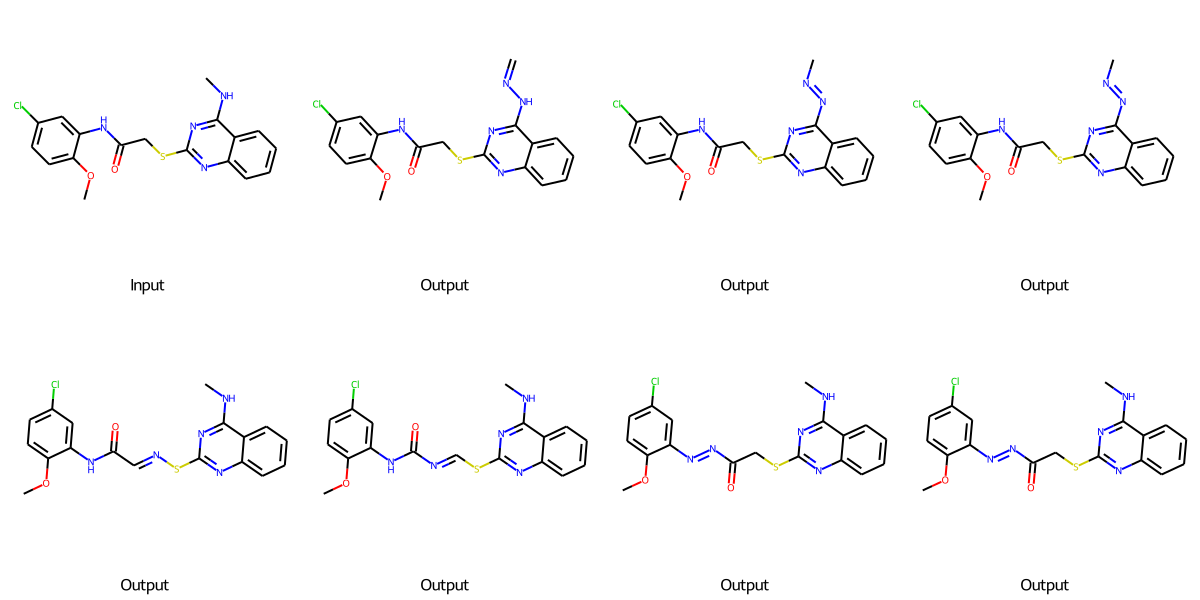

In [ ]:
m = InsertAtom()
outputs = m(mols[0])
outputs = to_mols(outputs)
outputs = [i for i in outputs if i is not None]
draw_mols([mols[0]]+to_mols(outputs[:7]), legends=['Input']+['Output']*8, mols_per_row=4)

### Crossover

Crossover operations take in a pair of molecules and generate new molecules with features from each parent

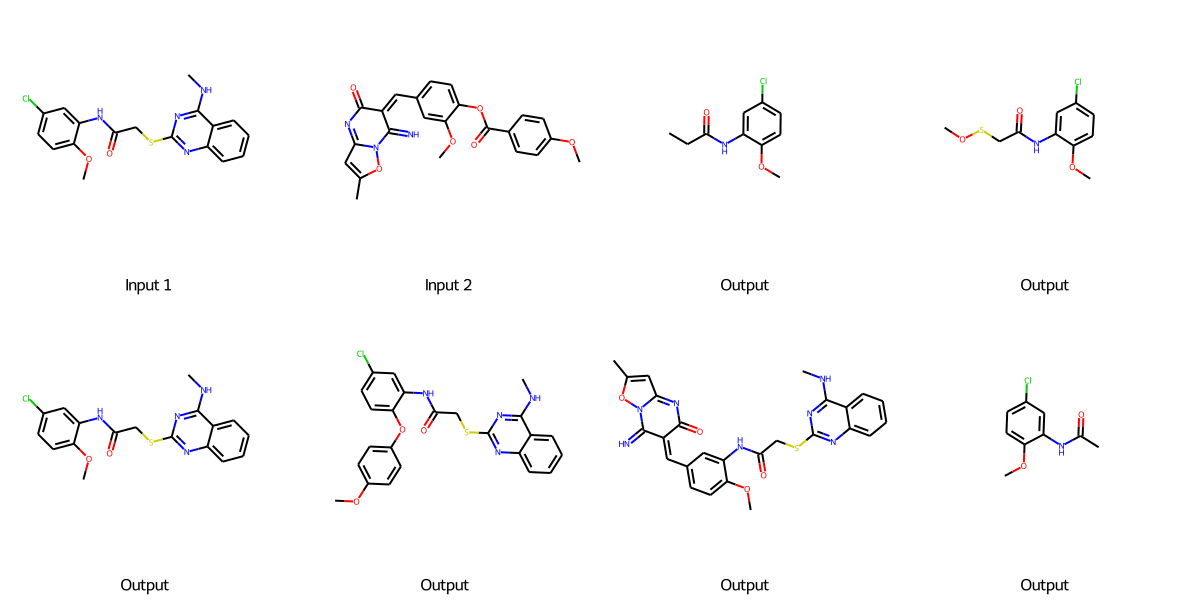

In [ ]:
cs = FragmentCrossover()
outputs = cs.crossover([mols[0], mols[1]])
outputs = to_mols(outputs)
outputs = [i for i in outputs if i is not None]
draw_mols([mols[0], mols[1]]+outputs[:6], legends=['Input 1', 'Input 2'] + ['Output']*6,
         mols_per_row=4)

## MPO Optimization

To look at how the combichem module orchestrates different mutations and crossovers, we first need a score function to optimize against. We'll use a multiparameter optimization goal of maximizing QED, LogP and SA score. This score function is defined in the following template

We set the following hard filters:
- `ValidityFilter`: Only valid compounds
- `SingleCompoundFilter`: Only single compounds
- `MolWtFilter`: Molecular weight less than 500 g/mol
- `HBDFilter`: Less than or equal to 5 hydrogen bond donors
- `HBAFilter`: Less than or equal to 10 hydrogen bond acceptors
- `LogPFilter`: LogP less than 5

Next we set up our soft filters which will serve as our score. For each property (QED, LogP, SA), we scale the value:
- QED scaled between `[0,2]`
- LogP scaled between `[0,1]`
- SA score scaled between `[0,1]`

This weights LogP and SA score evenly, giving double weight to QED score

In [ ]:
def scale_sa(sa):
    return (10-sa)/9

def scale_logp(logp):
    logp = logp/5
    logp = min(max(logp,0),1)
    return logp

def scale_qed(qed):
    return 2*qed

template = Template([ValidityFilter(), 
                     SingleCompoundFilter(), 
                     MolWtFilter(None, 500),
                     HBDFilter(None, 5),
                     HBAFilter(None, 10),
                     LogPFilter(None, 5)
                     ],
                    [QEDFilter(None, None, score=PropertyFunctionScore(scale_qed)),
                     SAFilter(None, None, score=PropertyFunctionScore(scale_sa)),
                     LogPFilter(None, None, score=PropertyFunctionScore(scale_logp))], 
                    fail_score=-1., log=False)

### Combichem Module

The `CombiChem` module holds the mutators, crossovers, template and rewards associated with a combichem run.

We will use a series of SMARTS based mutators with fragment based crossover. Every iteration we will prune 70% of the library and keep a maximum of 500 compounds

In [ ]:
mutators = [
    ChangeAtom(),
    AppendAtom(),
    DeleteAtom(),
    ChangeBond(),
    InsertAtom(),
    AddRing()
]

mc = MutatorCollection(mutators)

crossovers = [FragmentCrossover()]

In [ ]:
cbc = CombiChem(mc, crossovers, template=template,
                prune_percentile=70, max_library_size=500, log=True, p_explore=0.2)

In [ ]:
set_global_pool(min(48, os.cpu_count()))

In [ ]:
cbc.add_data(df.smiles.values[:50])

In [ ]:
for i in range(12):
    cbc.step()
    print(cbc.library.score.mean())

3.047133618412355
3.2537939526494695
3.418638338036727
3.507796513563108
3.54000121743377
3.5449722094032965
3.5674340994617095
3.55446542940227
3.5568211028578562
3.56191952067556
3.5658639926404483
3.562594504462952


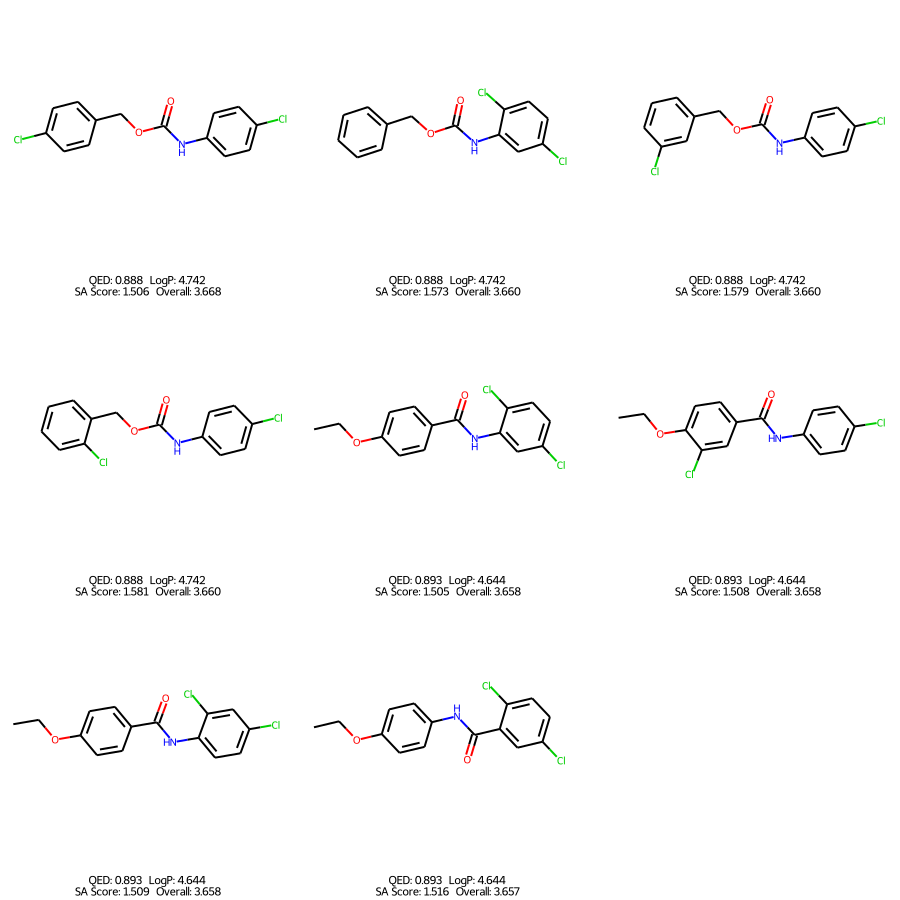

In [ ]:
subset = cbc.library[cbc.library.score>3.657]
samples = subset.smiles.values
values = subset.score.values
mols = [to_mol(i) for i in samples]
qeds = [qed(i) for i in mols]
logps = [logp(i) for i in mols]
sas = [sa_score(i) for i in mols]

legends = [f'QED: {qeds[i]:.3f}\tLogP: {logps[i]:.3f}\nSA Score: {sas[i]:.3f}\tOverall: {values[i]:.3f}'
          for i in range(len(samples))]

draw_mols(mols, legends=legends)

## Molecule Rediscoverey

A common combichem benchmark is the rediscovery of a target compound. This section shows how combichem can be used to rediscover Celecoxib

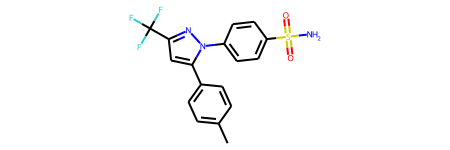

In [ ]:
target = 'Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2)cc1'
target_mol = to_mol(target)
target_mol

In [ ]:
template = Template([ValidityFilter(), 
                     SingleCompoundFilter(), 
                     ],
                    [FPFilter([ECFP4(target_mol)], 'ECFP4', 'tanimoto', score=PassThroughScore())], 
                    fail_score=-1., log=False)

In [ ]:
mutators = [
    ChangeAtom(),
    AppendAtom(),
    DeleteAtom(),
    ChangeBond(),
    InsertAtom(),
    AddRing()
]

mc = MutatorCollection(mutators)

crossovers = [FragmentCrossover()]

In [ ]:
cbc = CombiChem(mc, crossovers, template=template,
                prune_percentile=70, max_library_size=500, log=True, p_explore=0.2)

In [ ]:
set_global_pool(min(48, os.cpu_count()))

In [ ]:
cbc.add_data(df.smiles.values)

In [ ]:
cbc.library.score.max()

0.2835820895522388

In [ ]:
for i in range(60):
    cbc.step()
    print(cbc.library.score.mean())
    if cbc.library.score.max()==1.:
        print('Rediscovered')
        break

0.20923978442876012
0.29331786282874633
0.38464414362638083
0.5002706547102792
Rediscovered


## Reward Incorporation

The `CombiChem` module can also incorporate `Reward` modules. This section gives an example of how to do this.

For the reward, we will load a scikit-learn linear regression model trained to predict affinity against erbB1 using molecular fingerprints.

This score function is extremely simple and won't translate well to affinity. It is used as a lightweight example

In [ ]:
from mrl.train.reward import Reward
import torch

class FP_Regression_Score():
    def __init__(self, fname):
        self.model = torch.load(fname)
        self.fp_function = partial(failsafe_fp, fp_function=ECFP6)
        
    def __call__(self, samples):
        mols = to_mols(samples)
        fps = maybe_parallel(self.fp_function, mols)
        fps = [fp_to_array(i) for i in fps]
        x_vals = np.stack(fps)
        preds = self.model.predict(x_vals)
        return preds
    
# if in the repo
reward_function = FP_Regression_Score('../files/erbB1_regression.sklearn')

# if in Collab
# download_files()
# reward_function = FP_Regression_Score('files/erbB1_regression.sklearn')

reward = Reward(reward_function, weight=1.)

In [ ]:
template = Template([ValidityFilter(), 
                     SingleCompoundFilter(), 
                     MolWtFilter(None, 550)
                     ],
                    [], 
                    fail_score=-1., log=False)

In [ ]:
mutators = [
    ChangeAtom(),
    AppendAtom(),
    DeleteAtom(),
    ChangeBond(),
    InsertAtom(),
    AddRing()
]

mc = MutatorCollection(mutators)

crossovers = [FragmentCrossover()]

In [ ]:
cbc = CombiChem(mc, crossovers, template=template, rewards=[reward],
                prune_percentile=70, max_library_size=500, log=True, p_explore=0.2)

In [ ]:
set_global_pool(min(48, os.cpu_count()))

In [ ]:
cbc.add_data(df.smiles.values)

In [ ]:
for i in range(5):
    cbc.step()
    print(cbc.library.score.mean())

8.38129663848877
10.251605382442474
11.770093124389648
13.21962744140625
14.228362066268922
